In [4]:
import os
import sys

sys.path.append(os.path.abspath('..'))

In [75]:
import matplotlib.pyplot as plt
import torch
import os
import time
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils

from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from tqdm import tqdm 

from learnable_priors.models.conv_net import ConvNetPrior, InvConvNetPrior
from nn.nets import MLP, ConvNet, InvConvNet
from models.bae import BAE
from distributions import DiagonalNormal, ConditionalNormal, ConditionalBernoulli
from samplers import AdaptiveSGHMC, SGHMC
from priors import PriorNormal
from utils import ensure_dir, set_seed, DensityEstimator, inf_loop
from wasserstein_dist import TransformNet, distributional_sliced_wasserstein_distance

In [8]:
# Utility function used to sample from induced functional prior of BAE
def sample_autoencoder_prior(X, encoder_prior, decoder_prior, n_samples):
    samples = []
    
    for _ in range(n_samples):
        sample = encoder_prior.sample(X, 1)
        sample = decoder_prior.sample(sample, 1)
        
        samples.append(sample)
        
    return torch.cat(samples)

In [13]:
SEED = 123

RESULT_DIR = "../exp/conv_mnist"
ensure_dir(RESULT_DIR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# Create a subset of MNIST dataset, which consists of only 0 digits

set_seed(SEED)

data = MNIST(root="../datasets", label=True)
train_loader, test_loader = data.get_data_loaders(1000)

x, y = next(iter(train_loader))

xs = []
ys = []

xs.append(x[torch.where(y==0)[0][:100], ...])
x_subset = torch.cat(xs)

dataset_subset = TensorDataset(x_subset)
dataloader_subset = DataLoader(dataset_subset, batch_size=64, shuffle=True)

# Priors

## Standard Gaussian Prior

In [76]:
# Let initialize the standard Gaussian Prior

set_seed(SEED)
latent_size = 50

W_prior_params = {'mean_init': 0., 'log_var_init': 0.}
b_prior_params = {'mean_init': 0., 'log_var_init': 0.}

encoder_prior = ConvNetPrior(
    1, latent_size,
    n_channels=[32, 64, 64, 128],
    kernel_sizes=[4, 4, 4, 4],
    strides=[2, 2, 2, 2],
    paddings=[1, 1, 1, 1],
    activation='leaky_relu',
    in_lambda=None,
    W_prior_dist="GaussianDistribution",
    b_prior_dist="GaussianDistribution",
    W_prior_params=W_prior_params,
    b_prior_params=b_prior_params)

decoder_prior = InvConvNetPrior(
    latent_size, 1, n_hiddens=[7*7*128], n_channels=[128, 64, 64],
    kernel_sizes=[4, 4, 4],
    strides=[1, 1, 2],
    paddings=[0, 0, 0],
    activation='leaky_relu',
    mid_lambda=lambda x: x.view(x.shape[0], 128, 7, 7),
    out_lambda=lambda x: torch.sigmoid(x.view(x.shape[0], 1, 28, 28)),
    W_prior_dist="GaussianDistribution",
    b_prior_dist="GaussianDistribution",
    W_prior_params=W_prior_params,
    b_prior_params=b_prior_params)

encoder_prior = encoder_prior.to(device)
decoder_prior = decoder_prior.to(device)

Sample from functional prior induced by the standard Gaussian prior over parameters

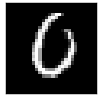

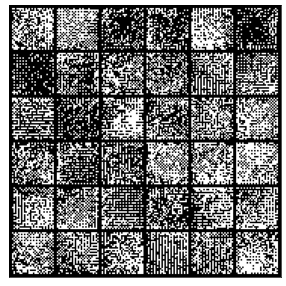

In [77]:
# Given an MNIST sample
# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)

grid_img = vutils.make_grid(x[0].view(1, 1, 28, 28).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::64].view(x_pred[::64].shape[0], 1, 28, 28).cpu().float(), nrow=6)
fig = plt.figure(figsize=(6, 6), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

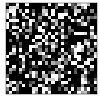

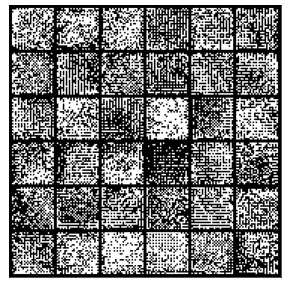

In [78]:
# Given a noisy input data
# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)
x = torch.randn_like(x).clamp(0, 1).to(device)

grid_img = vutils.make_grid(x[0].view(1, 1, 28, 28).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::64].view(x_pred[::64].shape[0], 1, 28, 28).cpu().float(), nrow=6)
fig = plt.figure(figsize=(6, 6), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

## Optimized Prior

Load the optimized prior

In [130]:
encoder_prior.load_state_dict(torch.load("../exp/conv_mnist/prior/encoder_prior.pt"))
decoder_prior.load_state_dict(torch.load("../exp/conv_mnist/prior/decoder_prior.pt"))

<All keys matched successfully>

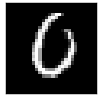

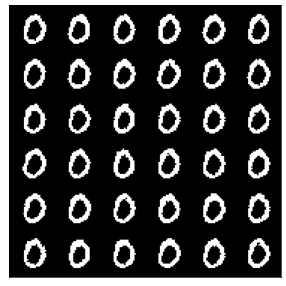

In [80]:
# Given an MNIST input
# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)

grid_img = vutils.make_grid(x[0].view(1, 1, 28, 28).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::64].view(x_pred[::64].shape[0], 1, 28, 28).cpu().float(), nrow=6)
fig = plt.figure(figsize=(6, 6), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()


del x_pred
del x
torch.cuda.empty_cache()

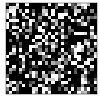

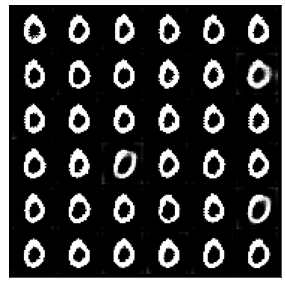

In [81]:
# Given a noisy input data
# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)
x = torch.randn_like(x).clamp(0, 1).to(device)

grid_img = vutils.make_grid(x[0].view(1, 1, 28, 28).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::64].view(x_pred[::64].shape[0], 1, 28, 28).cpu().float(), nrow=6)
fig = plt.figure(figsize=(6, 6), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

# Posterior

## Initialize Bayesian Autoencoder with Optimized Prior

In [86]:
data = MNIST(root="../datasets", label=True)
_, test_loader = data.get_data_loaders(100)

In [103]:
set_seed(SEED)
train_loader, _ = data.get_data_loaders(20000)

xs, ys = next(iter(train_loader))
xs = xs[torch.where(ys!=0)[0][:200], ...]

dataset = TensorDataset(xs)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [87]:
encoder_net = ConvNet(1, latent_size,
                  n_channels=[32, 64, 64, 128],
                  kernel_sizes=[4, 4, 4, 4],
                  strides=[2, 2, 2, 2],
                  paddings=[1, 1, 1, 1],
                  activation='leaky_relu',
                  in_lambda=None)

decoder_net = InvConvNet(
        latent_size, 1, n_hiddens=[7*7*128], n_channels=[128, 64, 64],
        kernel_sizes=[4, 4, 4],
        strides=[1, 1, 2],
        paddings=[0, 0, 0],
        activation='leaky_relu',
        mid_lambda=lambda x: x.view(x.shape[0], 128, 7, 7),
        out_lambda=lambda x: torch.sigmoid(x.view(x.shape[0], 1, 28, 28)))


encoder_net = encoder_net.to(device)
decoder_net = decoder_net.to(device)

encoder = encoder_net
decoder = ConditionalBernoulli(decoder_net)

model = BAE(encoder=encoder, decoder=decoder,
            encoder_prior=encoder_prior, decoder_prior=decoder_prior)

model = model.to(device)

In [136]:
# Load the sampled parameters
RESULT_DIR = "../exp/conv_mnist/posterior_train_size_200"
SAMPLES_DIR = os.path.join(RESULT_DIR, "param_samples")

model.set_samples(SAMPLES_DIR, cache=True)

100%|██████████| 32/32 [00:00<00:00, 109.22it/s]


## Reconstruct Images

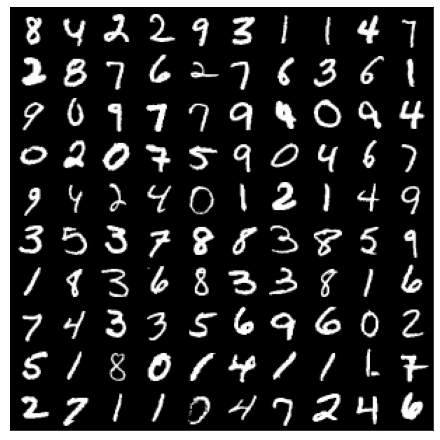

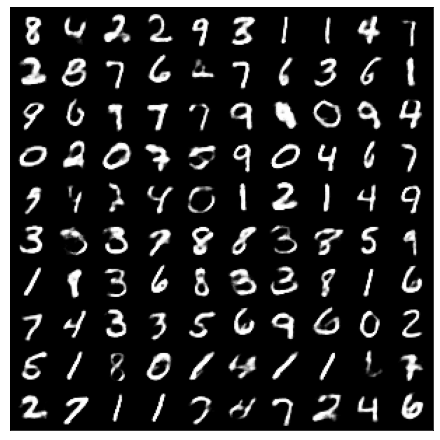

In [137]:
model.eval()
iter_data = iter(test_loader)
with torch.no_grad():
    x = next(iter_data)
    x = next(iter_data)
    x = x[0].float().to(device)
    x_pred = model.predict(x, randomness=True)

grid_img = vutils.make_grid(x.view(x.shape[0], 1, 28, 28).cpu().float(), nrow=10)

fig = plt.figure(figsize=(8, 8), dpi=70)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

grid_img = vutils.make_grid(x_pred.view(x_pred.shape[0], 1, 28, 28).cpu().float(), nrow=10)

fig = plt.figure(figsize=(8, 8), dpi=70)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()


Visualize the uncertainty estimates

In [138]:
model.eval()

x_pred = []
for i in range(len(model.encoder_samples)):
    encoder_params, decoder_params = model.load_samples(i)
    model.encoder_params = encoder_params
    model.decoder_params = decoder_params

    x_pred.append(model.decoder(model.encoder(x)))

x_pred = torch.stack(x_pred, dim=0)
x_pred_std = torch.std(x_pred, dim=0)

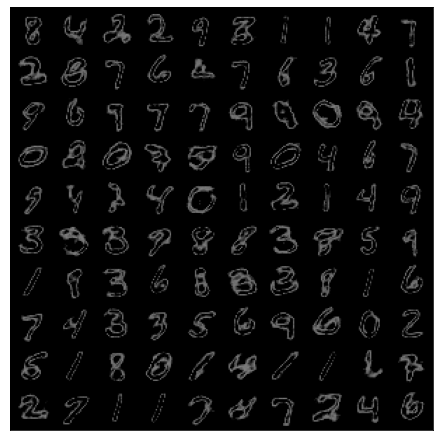

In [139]:
grid_img = vutils.make_grid(x_pred_std.view(x_pred_std.shape[0], 1, 28, 28).cpu().float(), nrow=10, normalize=False)

fig = plt.figure(figsize=(8, 8), dpi=70)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

## Generate Images

Generate latent codes

In [140]:
set_seed(SEED)

# Generate latent codes
model.set_samples(SAMPLES_DIR)

model.eval()
with torch.no_grad():
    print('Building latent codes...')
    z = []
    for i, x in tqdm(enumerate(train_loader)):
        x = x[0].to(device)
        z.append(model.encode(x, randomness=True))
    z = torch.cat(z).detach().cpu().numpy()
    np.save(os.path.join(RESULT_DIR, "train_z.npy"), z)

0it [00:00, ?it/s]

Building latent codes...


4it [00:01,  3.35it/s]


Fit Dirichlet Process Mixture Model

In [141]:
set_seed(SEED)

density_estimator = DensityEstimator(method="gmm_dirichlet", n_components=20)

z = np.load(os.path.join(RESULT_DIR, "train_z.npy"))
density_estimator.fit(z)
density_estimator.save_model(os.path.join(RESULT_DIR, "gmm_dirichlet.pkl"))

density_estimator.load_model(os.path.join(RESULT_DIR, "gmm_dirichlet.pkl"))

model.set_density_estimator(density_estimator)

Initialization 0
Initialization converged: True	 time lapse 0.08162s	 ll 13787.85514


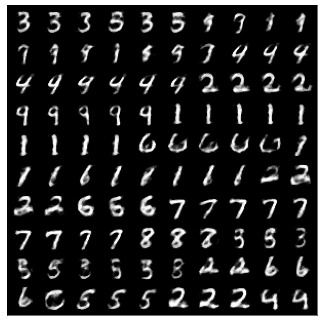

In [142]:
# Generate images
model.eval()
with torch.no_grad():
    samples, stds = model.sample(1000, return_std=True)
    
grid_img = vutils.make_grid(samples[::10].view(100, 1, 28, 28).cpu().float(), nrow=10)

fig = plt.figure(figsize=(8, 8*10), dpi=50)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

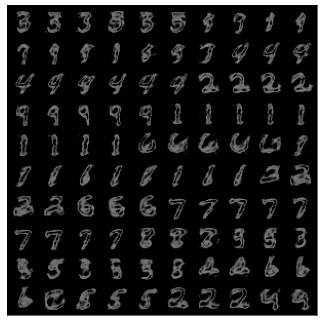

In [143]:
# Visualize the uncertainty
grid_img = vutils.make_grid(stds[::10].view(100, 1, 28, 28).cpu().float(), nrow=10)

fig = plt.figure(figsize=(8, 8*10), dpi=50)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()